# Fake News Detection using BERT

In this notebook, we build a binary text classifier to Fake News Articles from the Buzzfeed Dataset , a pretrained NLP model that can be used for transfer learning on text data.  We will use the [*ktrain* library](https://github.com/amaiya/ktrain), a lightweight wrapper around Keras to help train (and deploy) neural networks.  For more information on *ktrain*, see [this Medium post](https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c).

We will begin by installing *ktrain* and importing the required *ktrain* modules.

### Imports and Installations

In [1]:
# install ktrain
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string

#import metrics and preprocessing
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense,Embedding,SpatialDropout1D,LSTM,Bidirectional,Conv2D,Flatten
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import metrics
from keras import optimizers

%matplotlib inline

# import ktrain
import ktrain
from ktrain import text

Using TensorFlow backend.


using Keras version: 2.2.4


## STEP 1:  Load and Preprocess the Dataset

The `texts_from_folder` function will load the training and validation data from the specified folder and automatically preprocess it according to BERT's requirements.  In doing so, the BERT model and vocabulary will be automatically downloaded.

In [4]:
# download dataset
df=pd.read_csv('Cleaned CSV/buzzfeedclean.csv')


In [5]:
df['original_rating']=df['rating'].map({'mixture of true and false':0,'mostly false':1,'mostly true':2,'no factual content':3})
df=pd.get_dummies(df,columns=['rating'])

In [6]:
df.head(2)

,id,url,text,domain,source,lower text,target,nltklemma,spacylemma,spacylemma2,spacy_pos,spacy_pos2,original_rating,rating_mixture of true and false,rating_mostly false,rating_mostly true,rating_no factual content
0,1204,http://occupydemocrats.com/2016/09/23/donald-t...,"A few days ago, DonaldTrump despicable spawn ...",occupydemocrats.com,buzzfeed,"a few days ago, donaldtrump despicable spawn ...",0,day ago donaldtrump despicable spawn tweeted m...,"day ago , DonaldTrump despicable spawn tweet...","day ago , PROPN despicable spawn tweet meme ...",SPACE NOUN ADV PUNCT PROPN ADJ NOUN VERB NOUN ...,SPACE DET ADJ NOUN ADV PROPN ADJ NOUN VERB ADP...,2,0,0,1,0
1,1157,http://occupydemocrats.com/2016/09/19/just-50-...,A group of over fifty former intelligence off...,occupydemocrats.com,buzzfeed,a group of over fifty former intelligence off...,0,group fifty former intelligence official natio...,group intelligence official national securit...,group intelligence official national securit...,SPACE NOUN NOUN NOUN ADJ NOUN NOUN VERB NOUN V...,SPACE DET NOUN ADP ADP NUM ADJ NOUN NOUN CCONJ...,2,0,0,1,0


In [7]:
(x_train, y_train), (x_test, y_test), preproc=text.texts_from_df(df,
                                                                 text_column='text',
                                                                 label_columns=['target'],
                                                                 max_features=40000,
                                                                 maxlen=512,
                                                                 preprocess_mode='bert',
                                                                 val_pct=0.2)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


## STEP 2:  Load a pretrained BERT model and wrap it in a `ktrain.Learner` object

This step can be condensed into a single line of code, but we execute it as two lines for clarity. 

In [9]:
#works with tensorflow 1
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6,)

Is Multi-Label? False
maxlen is 512


AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [0]:
import numpy as np
columns=['rating_mixture of true and false','rating_mostly false','rating_mostly true','rating_no factual content'],

counter_weight={}
weights=df['target'].value_counts()

for n,wght in enumerate(weights):
  counter_weight[n]=(np.max(weights)/wght)
  

In [14]:
weights=df['target'].value_counts()
weights

0    1090
1     290
Name: target, dtype: int64

In [15]:
counter_weight

{0: 1.0, 1: 3.7586206896551726}

## STEP 3:  Train and Fine-Tune the Model on the IMDb dataset

We employ the `learner.fit_onecycle` method in *ktrain* that employs the use of a [1cycle learning  rate schedule](https://arxiv.org/pdf/1803.09820.pdf).  We use a learning rate of 2e-5 based on recommendations from [the original paper](https://arxiv.org/abs/1810.04805).

As can be seen, we achieve a **93.92% validation accuracy** in a single epoch.

In [0]:
#learner.fit_onecycle(2e-5,1,checkpoint_folder='/content/drive/My Drive/Capstone_DSI/Misinformation_detection/BERTModels/BinaryBuzzfeedBalanced',class_weight=counter_weight)

In [16]:
learner.autofit(4e-5, 20,early_stopping=5,reduce_on_plateau=2,checkpoint_folder='../Deeplearning Models/BERT',class_weight=counter_weight)



begin training using triangular learning rate policy with max lr of 4e-05...
Train on 1104 samples, validate on 276 samples
Epoch 1/20
1104/1104 [==============================] - 336s 305ms/step - loss: 1.0389 - acc: 0.6884 - val_loss: 0.5283 - val_acc: 0.7355
Epoch 2/20
1104/1104 [==============================] - 323s 293ms/step - loss: 0.7772 - acc: 0.7473 - val_loss: 0.5054 - val_acc: 0.7174
Epoch 3/20
1104/1104 [==============================] - 323s 292ms/step - loss: 0.6760 - acc: 0.7563 - val_loss: 0.4573 - val_acc: 0.7428
Epoch 4/20
1104/1104 [==============================] - 323s 293ms/step - loss: 0.5902 - acc: 0.7944 - val_loss: 0.5154 - val_acc: 0.7572
Epoch 5/20
1104/1104 [==============================] - 322s 292ms/step - loss: 0.4222 - acc: 0.8832 - val_loss: 0.6204 - val_acc: 0.7862
Epoch 6/20
1104/1104 [==============================] - 323s 292ms/step - loss: 0.3911 - acc: 0.8940 - val_loss: 0.6262 - val_acc: 0.7609
Epoch 7/20
1104/1104 [========================

Since it does not appear we are overfitting yet, we could train for an additional epoch or two for even higher accuracy.  

Feel free to try it out on your own.

In [0]:
#model=learner.model

In [0]:
model.load_weights('../Deeplearning Models/BERT/weights-03.hdf5')

In [66]:
cm=learner.validate(val_data=(x_test, y_test), class_names=['true','fake'])

KeyboardInterrupt: ignored

In [0]:
pred_prob=model.predict(x_test)

In [68]:
valid_pred_df=assess_model(pred_prob[:,1],y_test[:,1],0.5)

Float64Index([0.0, 1.0], dtype='float64')


,Predicted Real,Predicted Fake
index,,
Real Real,157,62
Real Fake,9,48


{'accuracy': 0.7427536231884058, 'f': 0.5748502994011976, 'precision': 0.43636363636363634, 'recall': 0.8421052631578947, 'fprate': 0.2831050228310502, 'tprate': 0.8421052631578947}


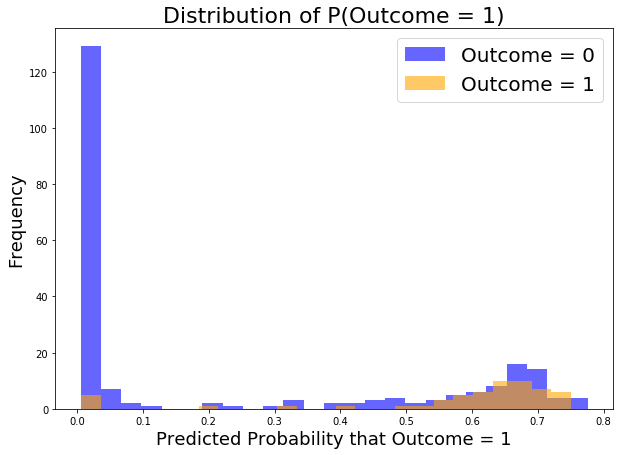

In [69]:
plotprob(valid_pred_df)

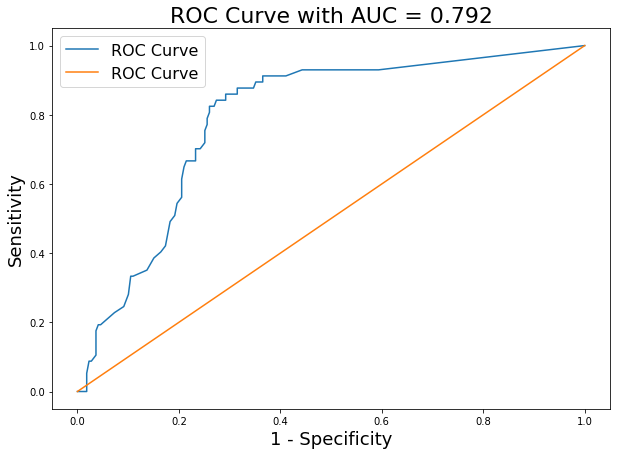

In [70]:
rocauccurve(valid_pred_df)

### Assessment Functions

In [0]:
## Prints a Confusion Matrix with columns and indexes labeled correctly
def printcm(Y,predictions,ground_truth):
    
    columns=pd.get_dummies(Y).columns
    print(columns)
    predictions=pd.DataFrame(predictions)
    predictions[0]=predictions[0].map({n:col for n,col in enumerate(columns)})

    columns2=['Real','Fake']
    cm=pd.DataFrame(confusion_matrix(ground_truth,predictions[0]),columns=[('Predicted '+str(x)) for x in columns2])
    cm['index']=cm['index']=[('Real '+str(x)) for x in columns2]
    cm.set_index('index',inplace=True)
    display(cm)

In [0]:
#sets recall to a certain threshold, then checks precision of that point.
def set_fprate(ground_truth, pred_proba,fp_threshold=0.10):
    error,max_error=0,0
    thresholds=np.linspace(1,0,2001)
    pred_df=pd.DataFrame()
    pred_df['true_values']=ground_truth
    pred_df['pred_prob']=pred_proba
    
    for prob in thresholds:
        x=FPR(pred_df,'true_values','pred_prob',prob)
        if x>fp_threshold:#if the recall is above the set point, return precision
            print(f'probability threshold where fp is {x} is {prob}')
            return prob



In [0]:
## prints  accuracy,f1,precision,recall scores and the confusion matrix
def assess_model(pred_prob,y_test,threshold):   

    pred_df=pd.DataFrame(pred_prob,columns=['pred_probs'])


    pred_df['true_values']=y_test
    pred_df['predict']=pred_df['pred_probs']>threshold
    pred_df['predict']=pred_df['predict'].astype(int)
    predictions=pred_df['predict'].values
    method={}
    
    method['accuracy']=accuracy_score(y_test,predictions)
    method['f']=f1_score(y_test,predictions)
    method['precision']=precision_score(y_test,predictions)
    method['recall']=recall_score(y_test,predictions)
    method['fprate']=FPR(pred_df,'true_values','pred_probs',threshold)
    method['tprate']=TPR(pred_df,'true_values','pred_probs',threshold)
    columns=pd.get_dummies(y_test).columns
    


    printcm(y_test,predictions,y_test)
    
    print(method)

    return pred_df

In [0]:
## returns precision and recall at a particular threshold
def custom_pr(true_col,pred_prob_col,threshold,beta=1):
    fbeta=0
    df=pd.DataFrame()
    df['true_col']=true_col
    df['pred_prob_col']=pred_prob_col

    TN = df[(df['true_col'] == 0) & (df['pred_prob_col'] <= threshold)].shape[0]
    FP = df[(df['true_col'] == 0) & (df['pred_prob_col'] > threshold)].shape[0]
    TP = df[(df['true_col'] == 1) & (df['pred_prob_col'] >= threshold)].shape[0]
    FN = df[(df['true_col'] == 1) & (df['pred_prob_col'] < threshold)].shape[0]
    #print(TN,FP,TP,FN)
    
    
    if TP==0:
        precision=0
        recall=0
    else:
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        
    if (precision==0 or recall==0):
        fbeta=0
    else:
        fbeta=(1+beta**2) * (precision * recall) / ((beta**2)*precision + recall)
    return [precision,recall]

In [0]:
#sets recall to a certain threshold, then checks precision of that point.
def set_recall(ground_truth, pred_proba,recall_threshold=0.95):
    error,max_error=0,0
    thresholds=np.linspace(1,0,2001)
    
    for prob in thresholds:
        if custom_pr(ground_truth,pred_proba, prob)[1]>recall_threshold:#if the recall is above the set point, return precision
            print(f'probability threshold is{prob}')
            return custom_pr(ground_truth,pred_proba, prob)



In [0]:
# plots a probability distribution of the predictions
def plotprob(pred_df):
# Create figure.
  plt.figure(figsize = (10,7))

# Create two histograms of observations.
  plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
          bins=25,
          color='b',
          alpha = 0.6,
          label='Outcome = 0')
  plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
          bins=25,
          color='orange',
          alpha = 0.6,
          label='Outcome = 1')

# Label axes.
  plt.title('Distribution of P(Outcome = 1)', fontsize=22)
  plt.ylabel('Frequency', fontsize=18)
  plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
  plt.legend(fontsize=20);
  pass

In [0]:
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

#define function to calculate f1 score for a particular threshold
def f1(df,true_col,pred_prob_col,threshold):
    TN = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    FP = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    TP = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    FN = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    if TP==0:
        precision=0
    else:
        precision=TP/(TP+FP)
        
    recall=TP/(TP+FN)
    if (precision==0 or recall==0):
        f1=0
    else:
        f1=2 * (precision * recall) / (precision + recall)
    return f1

In [0]:
#plots the receiver operating curve
def rocauccurve(pred_df):
  # Create figure.
  plt.figure(figsize = (10,7))
  # Create threshold values. (Dashed red line in image.)
  thresholds = np.linspace(0, 1, 200)
  # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
  tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
  fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

  # Plot ROC curve.
  plt.plot(fpr_values, # False Positive Rate on X-axis
          tpr_values,
          label='ROC Curve')
  # Plot ROC curve.
  plt.plot(thresholds, # False Positive Rate on X-axis
          thresholds,
          label='ROC Curve')
  # Label axes.
  plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
  plt.ylabel('Sensitivity', fontsize=18)
  plt.xlabel('1 - Specificity', fontsize=18)

  # Create legend.
  plt.legend(fontsize=16);